In [1]:
class Pars:
    pass

pars = Pars()
pars.cardTag = 'v16'
pars.category = 'comb'
pars.schemeFF = 'CLN'
pars.useMVA = False
pars.dataType = 0
pars.asimov = False
pars.unblinded = True
pars.noMCstats = False

# Imports

In [2]:
import sys, os, pickle, commands, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
sys.path.append('../Combine')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from analysis_utilities import drawOnCMSCanvas
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from combine_utilities import loadHisto4CombineFromRoot

Welcome to JupyROOT 6.12/07


In [4]:
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

In [5]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"
donotdelete = []

In [6]:
def createCardName(a):
    c = a.cardTag + a.category + '_' + a.schemeFF
    if a.useMVA:
        c += '_MVA'+useMVA
    if a.asimov:
        c += '_Asimov'
    elif a.dataType:
        c += '_onlyB0'
        if a.dataType == 2:
            c += 'bar'
    if not a.unblinded:
        c += '_blinded'
    if a.noMCstats:
        c += '_NoMCstats'
    return c

In [7]:
def getPostfitHistos(tag, out, histo_prefit, category, forceRDst=False):
    runName = tag + ('_RDstFixed' if forceRDst else '')

    # Get post-fit shapes
    if not out[-1] == '/': out += '/'
    n = out + 'fitDiagnostics{}.root'.format(runName)
    print 'Loading post-fit from:', n
    fFitDiagnostics = rt.TFile(n, 'READ')
    donotdelete.append(fFitDiagnostics)
    if forceRDst:
        fd = fFitDiagnostics.shapes_fit_b
    else:
        fd = fFitDiagnostics.shapes_fit_s

    histo_postfit = {}
    if category == 'comb':
        for catregName in [k.GetTitle() for k in fd.GetListOfKeys()]:
            c = catregName.split('_')[0]
            if not c in histo_postfit.keys():
                histo_postfit[c] = {}
            regName = catregName[len(c)+1:]
            histo_postfit[c][regName] = {}

            for n, h in histo_prefit[c][regName].iteritems():
                if '__' in n:
                    continue
                if 'data' in n:
                    histo_postfit[c][regName]['data'] = h.Clone(h.GetName() + '_data')
                else:
                    h_post = h.Clone(h.GetName() + '_postfit')
                    h_fit = fd.Get(catregName+'/'+n)
                    if not h_fit:
                        print n+' missing from '+c+' '+regName
                        continue
                    for i in range(1, h_post.GetNbinsX()+1):
                        h_post.SetBinContent(i, h_fit.GetBinContent(i))
                        h_post.SetBinError(i, h_fit.GetBinError(i))

                    histo_postfit[c][regName][n] = h_post

            for k in histo_prefit[c].keys():
                if not k.startswith('h2D_q2bin'):
                    continue
                if k in histo_postfit[c].keys():
                    break
                histo_postfit[c][k] = {}
                for n in histo_prefit[c][k].keys():
                    histo_postfit[c][k][n] = histo_prefit[c][k][n].Clone()
                    histo_postfit[c][k][n].Reset()
    else:
        for regName in [k.GetTitle() for k in fd.GetListOfKeys()]:
            histo_postfit[regName] = {}

            for n, h in histo_prefit[regName].iteritems():
                if '__' in n:
                    continue
                if 'data' in n:
                    histo_postfit[regName]['data'] = h.Clone(h.GetName() + '_data')
                else:
                    h_post = h.Clone(h.GetName() + '_postfit')
                    h_fit = fd.Get(regName+'/'+n)
                    if not h_fit:
                        print n+' missing from '+regName
                        continue
                    for i in range(1, h_post.GetNbinsX()+1):
                        h_post.SetBinContent(i, h_fit.GetBinContent(i))
                        h_post.SetBinError(i, h_fit.GetBinError(i))

                    histo_postfit[regName][n] = h_post

        for k in histo_prefit.keys():
            if not k.startswith('h2D_q2bin'): continue
            histo_postfit[k] = {}
            for n in histo_prefit[k].keys():
                histo_postfit[k][n] = histo_prefit[k][n].Clone()
                histo_postfit[k][n].Reset()

    return histo_postfit

In [8]:
histo_file_dir = '/storage/user/ocerri/BPhysics/data/_root/histos4combine/'

In [9]:
label_dic = {'data'     : 'Data',
             'mu'       : 'B^{0}#rightarrow D*#mu^{+}#nu',
             'tau'      : 'B^{0}#rightarrow D*#tau^{+}#nu',
             
             'DstmD0'   : 'B^{0}#rightarrow D*D^{0}X',
             'DstmDp'   : 'B^{0}#rightarrow D*D^{+}X',
             'DstmDsp'   : 'B^{0}#rightarrow D*D_{s}^{+}X',
             'BmDstmHc' : 'B^{-}#rightarrow D*H_{c}(#muX)',
             'BpDstmHc' : 'B^{+}#rightarrow D*H_{c}(#muX)',
             'antiB0DstmHc' : '#bar{B}^{0}#rightarrow D*H_{c}(#muX)',
             
             'DstPi0': 'B^{0}#rightarrow D**(D*#pi^{0})#mu#nu',
             'DstPip': 'B^{+}#rightarrow D**(D*#pi^{+})#mu#nu',
             'DstPipPim': 'B^{0}#rightarrow D**(D*#pi^{+}#pi^{-})#mu#nu',
             'DstPi0Pi0': 'B^{0}#rightarrow D**(D*#pi^{0}#pi^{0})#mu#nu',
             'DstPipPi0': 'B^{+}#rightarrow D**(D*#pi^{+}#pi^{0})#mu#nu',
             
             'TauDstPi0' : 'B^{0}#rightarrow D**(D*#pi^{0})#tau#nu',
             'TauDstPip' : 'B^{+}#rightarrow D**(D*#pi^{+})#tau#nu',
            }

# Load histograms

In [10]:
card_name = createCardName(pars)
outdir = '/storage/user/ocerri/BPhysics/Combine/results/' + card_name

In [11]:
histo = None
if pars.category == 'comb':
    histo = {}
    for c in ['low', 'mid', 'high']:
        print '---- Loading', c
        present = False
        while not present:
            n = len(glob(os.path.join(histo_file_dir, card_name.replace('comb', c)) + '_*.root'))
            if n>2:
                present = True
            else:
                print 'Waiting for ' + c
                time.sleep(10)
        histo[c] = loadHisto4CombineFromRoot(histo_file_dir, card_name.replace('comb', c))
else:
    loadShapeVar = 'card' in args.step
    histo = loadHisto4CombineFromRoot(histo_file_dir, card_name, loadShapeVar=loadShapeVar, verbose=False)

---- Loading low
---- Loading mid
---- Loading high


In [12]:
histo_post = getPostfitHistos(pars.cardTag, outdir, histo_prefit=histo, category=pars.category)

Loading post-fit from: /storage/user/ocerri/BPhysics/Combine/results/v16comb_CLN/fitDiagnosticsv16.root
BpDstmHc missing from high AddTk_mm_mHad
DstmD0 missing from high Dst_pt_q2bin0
DstmD0 missing from high Est_mu_q2bin0
DstmD0 missing from high M2_miss_q2bin0
DstmD0 missing from high Unrolled_q2bin0
DstmD0 missing from high mu_pt_q2bin0
BmDstmHc missing from low AddTk_pp_mHad
BmDstmHc missing from mid AddTk_pp_mHad
DstmD0 missing from mid Dst_pt_q2bin0
BmDstmHc missing from mid Dst_pt_q2bin0
DstmD0 missing from mid Est_mu_q2bin0
BmDstmHc missing from mid Est_mu_q2bin0
DstmD0 missing from mid M2_miss_q2bin0
BmDstmHc missing from mid M2_miss_q2bin0
DstmD0 missing from mid Unrolled_q2bin0
BmDstmHc missing from mid Unrolled_q2bin0
DstmD0 missing from mid mu_pt_q2bin0
BmDstmHc missing from mid mu_pt_q2bin0


# Draw plots

In [13]:
groups = [
    ['DstmD0', 'DstmDp', 'DstmDsp',
     'BmDstmHc', 'BpDstmHc', 'antiB0DstmHc',
    ],
    
    ['DstPi0', 'DstPip', 'DstPipPim', 'DstPi0Pi0', 'DstPipPi0'],
    
    ['TauDstPi0', 'TauDstPip']
]

In [28]:
category = 'low'
region = 'M2_miss_q2bin3'
xTitle = 'M_{miss}^{2} [GeV]'

hDic = histo_post[category][region]

In [29]:
hDic['tau'].GetXaxis().SetTitle(xTitle)
hDic['tau'].GetYaxis().SetTitle('Events / bin')

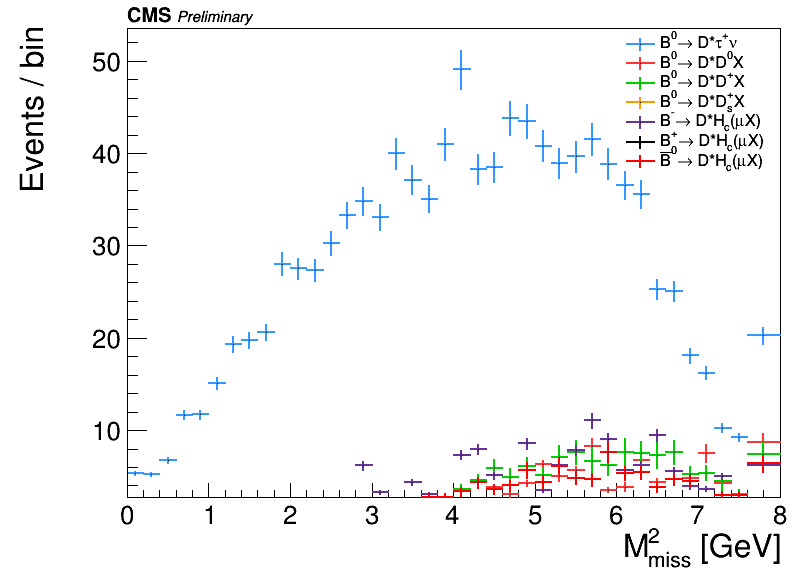

In [30]:
processes = groups[0]

leg = rt.TLegend(0.78, 0.7, 0.98, 0.94)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
        
hList = []
for ip, p in enumerate(['tau'] + processes):
    hDic[p].SetLineColor(std_color_list[ip])
    hList.append(hDic[p])
    leg.AddEntry(hDic[p], label_dic[p], 'lep')
    
c = drawOnCMSCanvas(CMS_lumi, hList, 'same')

leg.Draw()